<a href="https://colab.research.google.com/github/PauloCh-PAVIC/p_programming_PAVIC/blob/master/U_NET_BUSI_SEGMENTATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing libs
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tqdm import tqdm
from matplotlib import pyplot as plt
import tensorflow
import random
import sys
import random
import math
import re
import time
import glob
import shutil
tensorflow.__version__

'2.9.2'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!cp /content/gdrive/MyDrive/datasets/dataset.zip /content/

In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/benign/
  inflating: dataset/benign/benign (1).png  
  inflating: dataset/benign/benign (1)_mask.png  
  inflating: dataset/benign/benign (10).png  
  inflating: dataset/benign/benign (10)_mask.png  
  inflating: dataset/benign/benign (100).png  
  inflating: dataset/benign/benign (100)_mask.png  
  inflating: dataset/benign/benign (100)_mask_1.png  
  inflating: dataset/benign/benign (101).png  
  inflating: dataset/benign/benign (101)_mask.png  
  inflating: dataset/benign/benign (102).png  
  inflating: dataset/benign/benign (102)_mask.png  
  inflating: dataset/benign/benign (103).png  
  inflating: dataset/benign/benign (103)_mask.png  
  inflating: dataset/benign/benign (104).png  
  inflating: dataset/benign/benign (104)_mask.png  
  inflating: dataset/benign/benign (105).png  
  inflating: dataset/benign/benign (105)_mask.png  
  inflating: dataset/benign/benign (106).png  
  inflating: dataset/benign/benign (106)_mask.png  
  inflatin

In [ ]:
#define path dataset base
base_path = 'dataset'
for dirpath, dirnames, filenames in os.walk(base_path):
  print(f"There are {len(dirnames)} directories and {len(filenames)} in directory {dirpath}.")

There are 2 directories and 0 in directory dataset.
There are 0 directories and 421 in directory dataset/malignant.
There are 0 directories and 891 in directory dataset/benign.


In [ ]:
def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)

In [ ]:
create_dir('dataset_final/train/images')
create_dir('dataset_final/train/mask')

In [ ]:
#move all masks
src_dir = "dataset/benign/"
dst_dir = "dataset_final/train/mask"
for jpgfile in glob.iglob(os.path.join(src_dir, "*mask*")):
    #print(jpgfile)
    shutil.move(jpgfile, dst_dir)

In [ ]:
#Move all images
src_dir = "dataset/benign/"
dst_dir = "dataset_final/train/images"
for jpgfile in glob.iglob(os.path.join(src_dir, "*.png")):
    shutil.move(jpgfile, dst_dir)

In [ ]:
path_train='dataset_final/train/'
path_train

'dataset_final/train/'

In [ ]:
train_ids = next(os.walk(path_train+'images'))[2]
train_ids

['benign (247).png',
 'benign (283).png',
 'benign (128).png',
 'benign (380).png',
 'benign (172).png',
 'benign (390).png',
 'benign (183).png',
 'benign (366).png',
 'benign (11).png',
 'benign (53).png',
 'benign (249).png',
 'benign (207).png',
 'benign (367).png',
 'benign (326).png',
 'benign (248).png',
 'benign (219).png',
 'benign (104).png',
 'benign (158).png',
 'benign (313).png',
 'benign (110).png',
 'benign (155).png',
 'benign (343).png',
 'benign (32).png',
 'benign (142).png',
 'benign (167).png',
 'benign (416).png',
 'benign (378).png',
 'benign (386).png',
 'benign (297).png',
 'benign (176).png',
 'benign (111).png',
 'benign (433).png',
 'benign (333).png',
 'benign (268).png',
 'benign (116).png',
 'benign (130).png',
 'benign (273).png',
 'benign (94).png',
 'benign (419).png',
 'benign (85).png',
 'benign (265).png',
 'benign (203).png',
 'benign (152).png',
 'benign (423).png',
 'benign (178).png',
 'benign (251).png',
 'benign (65).png',
 'benign (370).png'

In [ ]:
IMG_ALTURA = 224
IMG_LARGURA = 224
IMG_CANAIS = 3
N_CLASSES =  2

In [ ]:
len(train_ids)

437

In [ ]:
dataset_img = np.zeros((len(train_ids), IMG_ALTURA, IMG_LARGURA, IMG_CANAIS), dtype=np.uint8)
dataset_img.shape

(437, 224, 224, 3)

In [ ]:
dataset_mask = np.zeros((len(train_ids), IMG_ALTURA, IMG_LARGURA, 1), dtype=np.bool)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [ ]:
for n, id_, in tqdm(enumerate(train_ids), total=len(train_ids)):
  filename = path_train +'images/'+ id_
  img_id = filename.split('/')[-1].split('.')[0]
  #print(path)
  img = cv2.imread(filename)[:, :, :IMG_CANAIS] #ler imagens
  img = cv2.resize(img, (IMG_ALTURA, IMG_LARGURA)) # redimensionar
  dataset_img[n] = img
  mask = np.zeros((IMG_ALTURA, IMG_LARGURA, 1), dtype=np.bool) #empty mask (0)
  for idx, mask_file in enumerate(glob.iglob(f'/content/dataset_final/train/mask/{img_id}*.png')):
    mask_ = cv2.imread(mask_file)
    mask_ = cv2.cvtColor(mask_, cv2.COLOR_BGR2GRAY)
    mask_ = np.expand_dims(cv2.resize(mask_, (IMG_ALTURA, IMG_LARGURA)), axis=-1)
    mask = np.maximum(mask, mask_)
  
  dataset_mask[n] = mask
  

  0%|          | 0/437 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
100%|██████████| 437/437 [00:04<00:00, 101.60it/s]


In [ ]:
dataset_mask.shape, dataset_img.shape

((437, 224, 224, 1), (437, 224, 224, 3))

Text(0.5, 1.0, 'Mask')

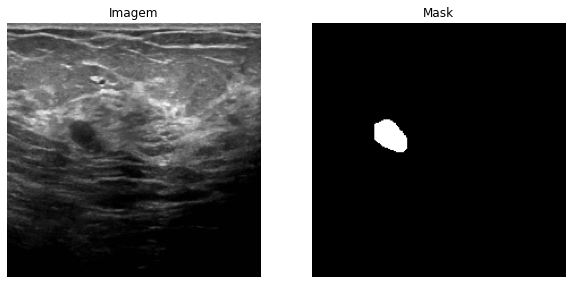

In [ ]:
id_img = 1
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
plt.imshow(dataset_img[id_img])
plt.axis('off')
plt.title("Imagem")
fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(dataset_mask[id_img]), cmap='gray')
plt.axis('off')
plt.title("Mask")

In [ ]:

# Treinamento, Validação, Teste
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(dataset_img, dataset_mask, test_size = 0.20, random_state = 42)

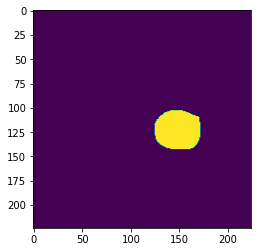

In [ ]:
plt.imshow(y_val[1].squeeze())

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, ReLU, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

In [ ]:

# =====================================================
# define U-Net model architecture

def build_unet(img_shape):
    # input layer shape is equal to patch image size
    inputs = Input(shape=img_shape)

    # rescale images from (0, 255) to (0, 1)
    rescale = Rescaling(scale=1. / 255, input_shape=(IMG_ALTURA, IMG_LARGURA, IMG_CANAIS))(inputs)
    previous_block_activation = rescale  # Set aside residual

    contraction = {}
    # # Contraction path: Blocks 1 through 5 are identical apart from the feature depth
    for f in [16, 32, 64, 128]:
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
        x = Dropout(0.1)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        contraction[f'conv{f}'] = x
        x = MaxPooling2D((2, 2))(x)
        previous_block_activation = x

    c5 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    previous_block_activation = c5

    # Expansive path: Second half of the network: upsampling inputs
    for f in reversed([16, 32, 64, 128]):
        x = Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(previous_block_activation)
        x = concatenate([x, contraction[f'conv{f}']])
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = Dropout(0.2)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        previous_block_activation = x

    outputs = Conv2D(filters=2, kernel_size=(1, 1), activation="softmax")(previous_block_activation)

    return Model(inputs=inputs, outputs=outputs)


# build model
model = build_unet(img_shape=(IMG_LARGURA, IMG_ALTURA, IMG_CANAIS))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 224, 224, 16  448         ['rescaling_2[0][0]']            
                                )                                                                 
                                                                                            

In [ ]:
model_checkpoint_filepath = '/content/checkpoints/'
create_dir(model_checkpoint_filepath)

In [ ]:
model_path = '/content/model/'
create_dir(model_path)

In [ ]:
def display_images(instances, rows=2, titles=None):
    """
    :param instances:  list of images
    :param rows: number of rows in subplot
    :param titles: subplot titles
    :return:
    """
    n = len(instances)
    cols = n // rows if (n / rows) % rows == 0 else (n // rows) + 1

    # iterate through images and display subplots
    for j, image in enumerate(instances):
        fig = plt.figure(figsize=(10, 7))
        plt.subplot(rows, cols, j + 1)
        plt.title('') if titles is None else plt.title(titles[j])
        plt.axis("off")
        plt.imshow(image)

    # show the figure
    plt.show()

In [ ]:
# =======================================================
# add callbacks, compile model and fit training data

# save best model with maximum validation accuracy
checkpoint = ModelCheckpoint(model_checkpoint_filepath, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")

# stop model training early if validation loss doesn't continue to decrease over 2 iterations
early_stopping = EarlyStopping(monitor="val_loss", patience=2, verbose=1, mode="min")


# create list of callbacks
callbacks_list = [checkpoint]  # early_stopping

# compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train and save model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=callbacks_list)
model.save(model_path)
print("model saved:", model_path)

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 0.4014 - accuracy: 0.8955
Epoch 1: val_accuracy improved from -inf to 0.93750, saving model to /content/checkpoints/


11/11 [==============================] - 9s 696ms/step - loss: 0.4014 - accuracy: 0.8955 - val_loss: 0.2902 - val_accuracy: 0.9375
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.3073 - accuracy: 0.9283
Epoch 2: val_accuracy did not improve from 0.93750
11/11 [==============================] - 3s 236ms/step - loss: 0.3073 - accuracy: 0.9283 - val_loss: 0.2776 - val_accuracy: 0.9375
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.2872 - accuracy: 0.9283
Epoch 3: val_accuracy did not improve from 0.93750
11/11 [==============================] - 3s 237ms/step - loss: 0.2872 - accuracy: 0.9283 - val_loss: 0.2544 - val_accuracy: 0.9375
Epoch 4/20
11/11 [==============================] - ETA: 0s - loss: 0.2640 - accuracy: 0.9283
Epoch 4: val_accuracy did not improve from 0.93750
11/11 [==============================] - 3s 250ms/step - loss: 0.2640 - accuracy: 0.9283 - val_loss: 0.2206 - val_accuracy: 0.9375
Epoch 5/20
11/11 [=======================

11/11 [==============================] - 6s 626ms/step - loss: 0.1857 - accuracy: 0.9306 - val_loss: 0.1704 - val_accuracy: 0.9408
Epoch 10/20
11/11 [==============================] - ETA: 0s - loss: 0.1884 - accuracy: 0.9371
Epoch 10: val_accuracy did not improve from 0.94078
11/11 [==============================] - 3s 237ms/step - loss: 0.1884 - accuracy: 0.9371 - val_loss: 0.1870 - val_accuracy: 0.9390
Epoch 11/20
11/11 [==============================] - ETA: 0s - loss: 0.1767 - accuracy: 0.9422
Epoch 11: val_accuracy improved from 0.94078 to 0.94809, saving model to /content/checkpoints/


11/11 [==============================] - 7s 675ms/step - loss: 0.1767 - accuracy: 0.9422 - val_loss: 0.1614 - val_accuracy: 0.9481
Epoch 12/20
11/11 [==============================] - ETA: 0s - loss: 0.1679 - accuracy: 0.9455
Epoch 12: val_accuracy improved from 0.94809 to 0.94947, saving model to /content/checkpoints/


11/11 [==============================] - 7s 659ms/step - loss: 0.1679 - accuracy: 0.9455 - val_loss: 0.1586 - val_accuracy: 0.9495
Epoch 13/20
11/11 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 0.9479
Epoch 13: val_accuracy improved from 0.94947 to 0.94969, saving model to /content/checkpoints/


11/11 [==============================] - 7s 675ms/step - loss: 0.1596 - accuracy: 0.9479 - val_loss: 0.1570 - val_accuracy: 0.9497
Epoch 14/20
11/11 [==============================] - ETA: 0s - loss: 0.1598 - accuracy: 0.9484
Epoch 14: val_accuracy improved from 0.94969 to 0.95343, saving model to /content/checkpoints/


11/11 [==============================] - 7s 662ms/step - loss: 0.1598 - accuracy: 0.9484 - val_loss: 0.1473 - val_accuracy: 0.9534
Epoch 15/20
11/11 [==============================] - ETA: 0s - loss: 0.1504 - accuracy: 0.9510
Epoch 15: val_accuracy improved from 0.95343 to 0.95502, saving model to /content/checkpoints/


11/11 [==============================] - 7s 640ms/step - loss: 0.1504 - accuracy: 0.9510 - val_loss: 0.1397 - val_accuracy: 0.9550
Epoch 16/20
11/11 [==============================] - ETA: 0s - loss: 0.1462 - accuracy: 0.9526
Epoch 16: val_accuracy improved from 0.95502 to 0.95557, saving model to /content/checkpoints/


11/11 [==============================] - 7s 672ms/step - loss: 0.1462 - accuracy: 0.9526 - val_loss: 0.1418 - val_accuracy: 0.9556
Epoch 17/20
11/11 [==============================] - ETA: 0s - loss: 0.1424 - accuracy: 0.9532
Epoch 17: val_accuracy improved from 0.95557 to 0.95785, saving model to /content/checkpoints/


11/11 [==============================] - 7s 653ms/step - loss: 0.1424 - accuracy: 0.9532 - val_loss: 0.1282 - val_accuracy: 0.9578
Epoch 18/20
11/11 [==============================] - ETA: 0s - loss: 0.1358 - accuracy: 0.9564
Epoch 18: val_accuracy improved from 0.95785 to 0.95826, saving model to /content/checkpoints/


11/11 [==============================] - 7s 664ms/step - loss: 0.1358 - accuracy: 0.9564 - val_loss: 0.1312 - val_accuracy: 0.9583
Epoch 19/20
11/11 [==============================] - ETA: 0s - loss: 0.1316 - accuracy: 0.9571
Epoch 19: val_accuracy improved from 0.95826 to 0.95961, saving model to /content/checkpoints/


11/11 [==============================] - 8s 740ms/step - loss: 0.1316 - accuracy: 0.9571 - val_loss: 0.1260 - val_accuracy: 0.9596
Epoch 20/20
11/11 [==============================] - ETA: 0s - loss: 0.1312 - accuracy: 0.9567
Epoch 20: val_accuracy did not improve from 0.95961
11/11 [==============================] - 3s 239ms/step - loss: 0.1312 - accuracy: 0.9567 - val_loss: 0.1336 - val_accuracy: 0.9556


model saved: /content/model/


In [ ]:
from enum import Enum

In [ ]:
# mask color codes
class MaskColorMap(Enum):
    Unlabelled = (155, 155, 155)
    Building = (60, 16, 152)
    Land = (132, 41, 246)
    Road = (110, 193, 228)
    Vegetation = (254, 221, 58)
    Water = (226, 169, 41)

1/1 [==============================] - 0s 19ms/step


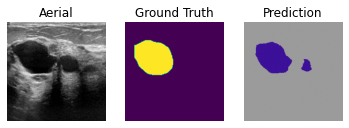

1/1 [==============================] - 0s 18ms/step


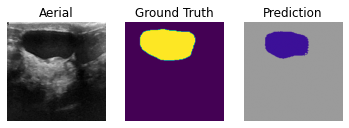

1/1 [==============================] - 0s 18ms/step


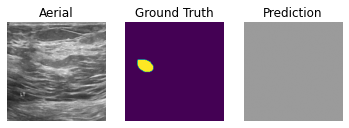

1/1 [==============================] - 0s 18ms/step


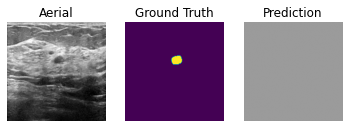

1/1 [==============================] - 0s 18ms/step


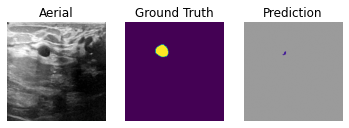

1/1 [==============================] - 0s 29ms/step


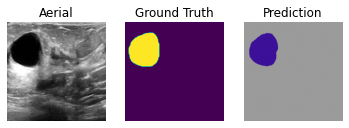

1/1 [==============================] - 0s 18ms/step


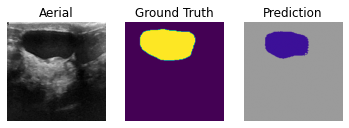

1/1 [==============================] - 0s 19ms/step


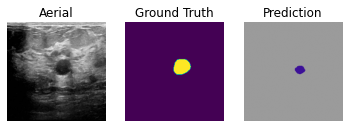

1/1 [==============================] - 0s 19ms/step


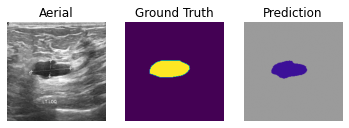

1/1 [==============================] - 0s 19ms/step


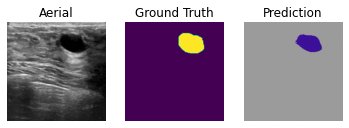

1/1 [==============================] - 0s 34ms/step


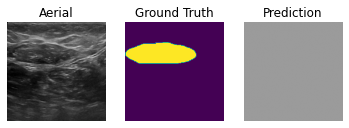

1/1 [==============================] - 0s 25ms/step


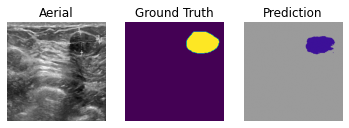

1/1 [==============================] - 0s 25ms/step


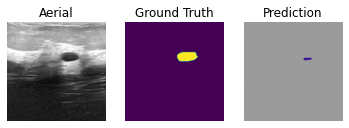

1/1 [==============================] - 0s 19ms/step


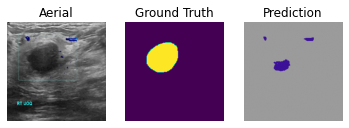

1/1 [==============================] - 0s 21ms/step


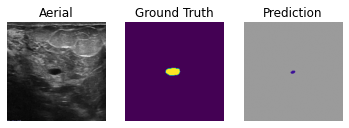

1/1 [==============================] - 0s 18ms/step


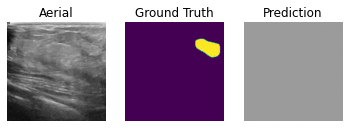

1/1 [==============================] - 0s 22ms/step


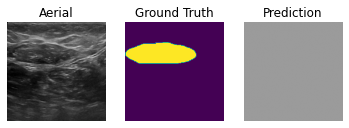

1/1 [==============================] - 0s 23ms/step


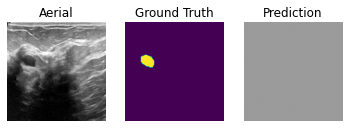

1/1 [==============================] - 0s 18ms/step


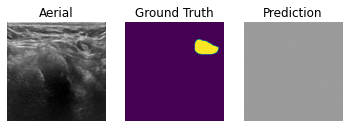

1/1 [==============================] - 0s 26ms/step


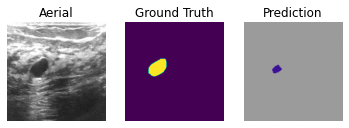

In [ ]:
# =====================================================
# Predict

def rgb_encode_mask(mask):
    # initialize rgb image with equal spatial resolution
    rgb_encode_image = np.zeros((mask.shape[0], mask.shape[1], 3))

    # iterate over MaskColorMap
    for j, cls in enumerate(MaskColorMap):
        # convert single integer channel to RGB channels
        rgb_encode_image[(mask == j)] = np.array(cls.value) / 255.
    return rgb_encode_image


for _ in range(20):
    # choose random number from 0 to test set size
    test_img_number = np.random.randint(0, len(X_val))

    # extract test input image
    test_img = X_val[test_img_number]

    # ground truth test label converted from one-hot to integer encoding
    ground_truth =  y_val[test_img_number].squeeze()# np.argmax(y_val[test_img_number], axis=-1)

    # expand first dimension as U-Net requires (m, h, w, nc) input shape
    test_img_input = np.expand_dims(test_img, 0)

    # make prediction with model and remove extra dimension
    prediction = np.squeeze(model.predict(test_img_input))

    # convert softmax probabilities to integer values
    predicted_img = np.argmax(prediction, axis=-1)

    # convert integer encoding to rgb values
    rgb_image = rgb_encode_mask(predicted_img)
    rgb_ground_truth = rgb_encode_mask(ground_truth)

    # visualize model predictions
    display_images(
        [test_img, ground_truth, rgb_image],
        rows=1, titles=['Aerial', 'Ground Truth', 'Prediction']
    )

In [ ]:
ground_truth = np.argmax(y_val[test_img_number], axis=-1)
ground_truth.shape

(224, 224)

1/1 [==============================] - 0s 18ms/step


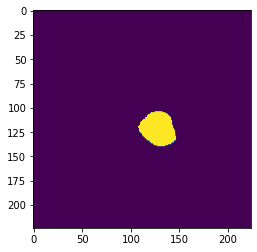

In [ ]:
test_img = X_val[15]
test_img_input = np.expand_dims(test_img, 0)
prediction = np.squeeze(model.predict(test_img_input))
# convert softmax probabilities to integer values
predicted_img = np.argmax(prediction, axis=-1)
np.unique(predicted_img)
plt.imshow(predicted_img)

#Paulo.... esssa foi a predição do modelo..... pelo menos segmentou alguma coisa
## Treinou só com os benignos,certo? Mesmo assim tem alguns que não foram detectados?Isso.
É so mudaro index ali encima pra ver como ficou, alguns casos nao pega nada....apesar que..... eh a rede Unet crua

ee...
nao sei se os dados tao legais

temosque ajustar e ver se as mask estao todas correta


Ta ai, agora tem o GTRUTH e o PREDICT
Vi que tinham alguns bem parecidos e outros nem tinham prediction
Que loucura

Essa pasta aí tá treinando com o train?